<a href="https://colab.research.google.com/github/hassantrms/hassan/blob/master/Copy_of_Copy_of_Step_4_5_Multivariate_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Regression

In most of the real life use cases there will be more than one independent variable, so the concept of having multiple independent variables is called as multivariate regression. The equation take the below form.

y = m_1 x_1 + m_2 x_2 + m_3 x_3 + . . .+ m_n x_n
Where, each independent variable is represented by x’s, and m’s are the corresponding coefficients.

We’ll be using the ‘statsmodels’ Python library to learn the basics of multivariate regression, as it provide more useful statistics results which is helpful from learning perspective. Once you understand the fundamental concepts, you can either use ‘scikit-learn’ or ‘statsmodels’ package as both are efficient.

In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&code_challenge=nTDxooLntNXP-ad95rv6FxwBAyJd0zItPQ4R3DGigGk&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: ··········


AuthorizationError: ignored

In [2]:
!pip install PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

class download_data_from_folder(object):
    def __init__(self,path):
        path_id = path[path.find('id=')+3:]
        self.file_list = self.get_files_in_location(path_id)
        self.unwrap_data(self.file_list)
    def get_files_in_location(self,folder_id):
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        return file_list
    def unwrap_data(self,file_list,directory='.'):
        for i, file in enumerate(file_list):
            print(str((i + 1) / len(file_list) * 100) + '% done copying')
            if file['mimeType'].find('folder') != -1:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    os.makedirs(os.path.join(directory, file['title']))
                print('Copying folder ' + os.path.join(directory, file['title']))
                self.unwrap_data(self.get_files_in_location(file['id']), os.path.join(directory, file['title']))
            else:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    downloaded = drive.CreateFile({'id': file['id']})
                    downloaded.GetContentFile(os.path.join(directory, file['title']))
        return None

In [ ]:
data_path = 'https://drive.google.com/open?id=13hFQ09ptYr-Ud5xOJ0Xx4cV0akc1RnZw'
download_data_from_folder(data_path)

4.3478260869565215% done copying
8.695652173913043% done copying
13.043478260869565% done copying
17.391304347826086% done copying
21.73913043478261% done copying
26.08695652173913% done copying
30.434782608695656% done copying
34.78260869565217% done copying
39.130434782608695% done copying
43.47826086956522% done copying
47.82608695652174% done copying
52.17391304347826% done copying
56.52173913043478% done copying
60.86956521739131% done copying
65.21739130434783% done copying
69.56521739130434% done copying
73.91304347826086% done copying
78.26086956521739% done copying
82.6086956521739% done copying
86.95652173913044% done copying
91.30434782608695% done copying
95.65217391304348% done copying
100.0% done copying


In [3]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from sklearn.model_selection import train_test_split

%matplotlib inline

### Housing data



The housing data contains sales prices of houses in the city of Windsor. Below is the brief description about each variables.
- price: sale price of a house
- lotsize: the lot size of a property in square feet
- bedrooms: number of bedrooms
- bathrms: number of full bathrooms
- stories: number of stories excluding basement
- driveway: does the house has a driveway ?
- recroom: does the house has a recreational room ?
- fullbase: does the house has a full finished basement ?
- gashw: does the house uses gas for hot water heating ?
- airco: does the house has central air conditioning ?
- garagepl: number of garage places
- prefarea: is the house located in the preferred neighbourhood of the city ?

In [4]:
# Load data
df = pd.read_csv('Housing_Modified.csv')
print(df.head())

FileNotFoundError: ignored

### Data preprocessing

Let's build a model to predict the house price (dependent variable), considering rest of the variables as independent variables

Handling categorical variables
- Label Binarizer: This will replace the binary variable text with numeric vales. Lets use this function for the below binary variables of our current data set
    - driveway
    - recroom
    - fullbase
    - gashw
    - airco
    - prefarea

- Label Encoder: This will replace category level with number representation

- One Hot Encoder: This will convert n levels to n-1 new variable, and the new variables will use 1 to indicate the presence of level and 0 for otherwise. Note that before calling OneHotEncoder, we should use LabelEncoder to convert levels to number. Alternatively we can achieve the same using get_dummies of pandas package. This is much efficient to use as we can directly use it on the column with text description without having to convert to numbers first.

In [5]:
# Convert binary fields to numeric boolean fields
lb = preprocessing.LabelBinarizer()

df.driveway = lb.fit_transform(df.driveway)
df.recroom = lb.fit_transform(df.recroom)
df.fullbase = lb.fit_transform(df.fullbase)
df.gashw = lb.fit_transform(df.gashw)
df.airco = lb.fit_transform(df.airco)
df.prefarea = lb.fit_transform(df.prefarea)

df.head()

NameError: ignored

### Create dummy variables

In [6]:
# Create dummy variables for stories
df_stories = pd.get_dummies(df['stories'], prefix='stories', drop_first=True)

# Join the dummy variables to the main dataframe
df = pd.concat([df, df_stories], axis=1)
del df['stories']
df.head()

NameError: ignored

### Correlation plot

In [7]:
# lets plot correlation matrix using statmodels graphics packages's plot_corr

# create correlation matrix
corr = df.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

print(corr)

NameError: ignored

We can see from the plot that stories_one has a strong negative correlation with
stories_two. Let’s perform the VIF analysis to eliminate strongly correlated independent
variables

In [8]:
# Alternatively we can use seaborn package
import seaborn as sns

sns.heatmap(df.corr(), vmax=.8, square=True,annot=True,fmt='.1f')

NameError: ignored

### Variation Inflation Factor

VIF value of greater than 10 is a indicator of multicollinearity, and these variables should be excluded from the regression model.

In [9]:
# create a Python list of feature names
independent_variables = ['lotsize', 'bedrooms', 'bathrms','driveway', 'recroom',
                         'fullbase','gashw','airco','garagepl', 'prefarea',
                        'stories_one','stories_two','stories_three']

# use the list to select a subset from original DataFrame
X = df[independent_variables]
y = df['price']

thresh = 10

for i in np.arange(0,len(independent_variables)):
    vif = [variance_inflation_factor(X[independent_variables].values, ix) for ix in range(X[independent_variables].shape[1])]
    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print("vif :", vif)
        print('dropping \'' + X[independent_variables].columns[maxloc] + '\' at index: ' + str(maxloc))
        del independent_variables[maxloc]
    else:
        break

print('Final variables:', independent_variables)

NameError: ignored

We can see that VIF analysis has eliminated bedrooms greater than 10; however,
stories_one and stories_two have been retained.
Let’s run the first iteration of a multivariate regression model with the set of
independent variables that have passed the VIF analysis.
To test the model performance, the common practice is to split the data set into
80/20 (or 70/30) for train/test, respectively, and use the train data set to build the model.
Then apply the trained model on the test data set to evaluate the performance of the
model (

### Run first iteration of model

We split the data into train/test of 80/20 percent respectively.

In [10]:
# use the list to select a subset from original DataFrame
X = df[independent_variables]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# create a fitted model
lm = sm.OLS(y_train, X_train).fit()

# print the summary
print(lm.summary())

# make predictions on the testing set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
y_pred = lm.predict(X) # full data
print("Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

print("Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

print("Full Data MAE: ", metrics.mean_absolute_error(y, y_pred))
print("Full Data RMSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred)))

NameError: ignored

Lets remove recroom and stories_two has they have p value greater than 0.05 and re-run the model.

In [11]:
# create a Python list of feature names
independent_variables = ['lotsize', 'bathrms','driveway', 'fullbase','gashw', 'airco','garagepl', 
                         'prefarea','stories_one','stories_three']

# use the list to select a subset from original DataFrame
X = df[independent_variables]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# create a fitted model
lm = sm.OLS(y_train, X_train).fit()

# print the summary
print(lm.summary())

# make predictions on the testing set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
y_pred = lm.predict(X) # full data
print("Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

print("Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

print("Full Data MAE: ", metrics.mean_absolute_error(y, y_pred))
print("Full Data RMSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred)))

NameError: ignored

### Outliers

# **Regression Diagnostics**
There are a set of procedures and assumptions that need to be verified about our model
results, otherwise the model could be misleading. Let’s look at some of the important
regression diagnostics.
# **Outliers**
Data points that are far away from the fitted regression line are called outliers, and these
can impact the accuracy of the model. Plotting normalized residual vs. leverage will give
us a good understanding of the outlier’s points. Residual is the difference between actual
vs. predicted, and leverage is a measure of how far away the independent variable values
of observation are from those of the other observations

Plotting normalized residual vs leverage to understand the outlier points.

residual: difference between actual and predicted

leverage: is a measure of how far away the independent variable values of an observation are from those of the other observations

NameError: ignored

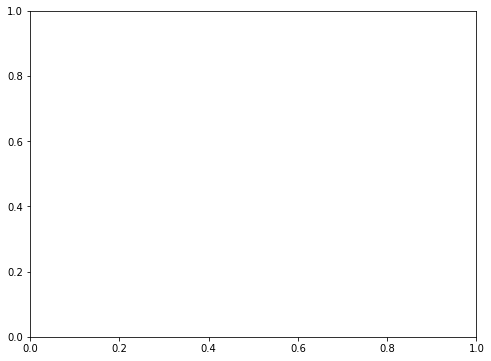

In [12]:
# lets plot the normalized residual vs leverage
from statsmodels.graphics.regressionplots import plot_leverage_resid2

ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)


From the chart, we see that there are many observations that have high leverage and
residual. Running a Bonferroni outlier test will give us p-values for each observation, and
those observations with p-value < 0.05 are the outliers affecting the accuracy. It is a good
practice to consult or apply business domain knowledge to make a decision on removing
the outlier points and rerunning the model; these points could be natural in the process,
although they are mathematically found as outliers

#### Bonferroni Outlier Test

Bonferroni p-value for the most extreme observation. If the p value is < 0.05 its an outlier.

In [13]:
# Find outliers #
# Bonferroni outlier test
test = lm.outlier_test()

print('Bad data points (bonf(p) < 0.05):')
print(test[test['bonf(p)'] < 0.05])

NameError: ignored

Homoscedasticity and Normality
The error variance should be constant, which is known as homoscedasticity, and the
error should be normally distributed

### Residual should be scattered and not have any patterns. The distribution of residual should be normal.

Homoscedasticity and Normality: The error variance should be constant which is known has homoscedasticity and the error should be normally distributed.

In [14]:
# plot to check homoscedasticity
plt.plot(lm.resid,'o')
plt.title('Residual Plot')
plt.ylabel('Residual')
plt.xlabel('Observation Numbers')
plt.show()

# normality plot
plt.hist(lm.resid, density=True)
plt.title('Error Normality Plot')
plt.xlabel('Residual')
plt.ylabel('Observation Numbers')


NameError: ignored

The relationships between the predictors and the outcome variable should be linear.
If the relationship is not linear then appropriate transformation (such as log, square root,
and higher order polynomials, etc.) should be applied to the dependent/independent
variable to fix the issue

You can check all the regressors using plot_partregress_grid function.

if the residual plot is not scattered or not normally distributed then there is a chance that independent variable is not having linear relationship and applying appropriate transformation to the independent variable will fix the issue.

In [15]:
# linearity plots
fig = plt.figure(figsize=(10,15))
fig = sm.graphics.plot_partregress_grid(lm, fig=fig)

NameError: ignored

<Figure size 720x1080 with 0 Axes>

# **Overfitting and Underfitting**
Underfitting occurs when the model does not fit the data well and is unable to capture
the underlying trend in it. In this case, we can notice a low accuracy in training and test
data set.
Conversely, overfitting occurs when the model fits the data too well, capturing all the
noises. In this case, we can notice a high accuracy in the training data set, whereas the
same model will result in a low accuracy on the test data set. This means the model has
fitted the line so well to the train data set that it failed to generalize it to fit well on the
unseen data set. Figure 3-8 shows how the different fitting would look like for an earlier
discussed example use case. Choice of right order polynomial degree is very important
to avoid an overfitting or underfitting issue in regression. 





### Regularization

With increase in number of variables and increase in model complexity, the probability of over-fitting. Regularization is a technique to avoid over-fitting problem. Over-fitting occurs when the model fits the data too well capturing all the noises. In this case we can notice a high accuracy in the training data set, whereas the same model will result a low accuracy on test data set. This means the model has fitted the line so well to the train data set that it failed to generalize it to fit well on unseen data set. 

Statsmodel and the scikit-learn provides Ridge and LASSO(Least Absolute Shrinkage and Selection Operator) regression to handle over-fitting issue. With increase in model complexity, the size of coefficients increase exponentially, so the ridge and LASSO regression apply penalty to the magnitude of the co-efficients to handle the issue.  

Ridge Regression: Also known as Tikhonov regularization, use this when you have many of variables that add minor value to the model accuracy individually, however overall improves the model accuracy and can not be excluded form the model. Ridge regression will apply penalty to reduce the magnitude of the coeffecient of all variables that add minor value to the model accuracy. Adds penalty equivalent to square of the magnitude of coefficients, alpha is the regularization strength and must be a positive float. 
 
LASSO: This provides a sparse solution, suitable when you have large set of indepenent variables. The coefficients of the variables that add minor value to the model will be zero. Adds penalty equivalent to absolute value of the magnitude of coefficients. Model complexity decreases with increase in the values of alpha

Ridge regression: Also known as Tikhonov (L2) regularization, it guides parameters
to be close to zero but not zero. You can use this when you have many variables that
add minor value to the model accuracy individually, however overall improve the
model accuracy and cannot be excluded from the model. Ridge regression will apply a
penalty to reduce the magnitude of the coefficient of all variables that add minor value
to the model accuracy, adding penalty equivalent to the square of the magnitude of
coefficients. Alpha is the regularization strength and must be a positive float.

In [16]:
from sklearn import linear_model

# Load data
df = pd.read_csv('Grade_Set_2.csv')
df.columns = ['x','y']

for i in range(2,50):              # power of 1 is already there
    colname = 'x_%d'%i              # new var will be x_power
    df[colname] = df['x']**i

independent_variables = list(df.columns)
independent_variables.remove('y')

X= df[independent_variables]       # independent variable
y= df.y                            # dependent variable 

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# Ridge regression
lr = linear_model.Ridge(alpha=0.001)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("------ Ridge Regression ------")
print("Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

print("Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("Ridge Coef: ", lr.coef_)

# LASSO regression
lr = linear_model.Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("----- LASSO Regression -----")
print("Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

print("Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("LASSO Coef: ", lr.coef_)

FileNotFoundError: ignored